In [2]:
%load_ext autoreload
%autoreload 2
import sys
paths = ['../models', '../dataset', '../util']
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict, namedtuple
import os 
import sys
import glob
import scipy.misc as spm
import json
import pprint
import pandas as pd
from PIL import Image
from sklearn.feature_extraction.image import extract_patches_2d
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN 5110)


In [4]:
train_data = pd.read_csv('../data/validation/test.csv')

756
img_07451.jpg
OTHER


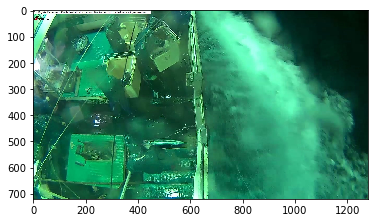

In [5]:
example = train_data.iloc[0]
print len(train_data)
print example.filename
print example.label

filename = '../data/train/{}/{}'.format(example.label, example.filename)
image = spm.imread(filename)
plt.imshow(image)
plt.show()

In [11]:
patch_width = 256
patch_height = 256
DATA_FOLDER = '../Data'
bboxes = defaultdict(list)
files = glob.glob(DATA_FOLDER + '/bounding_boxes/*.json')
for ff in files:
    with open(ff) as f:
        data = json.load(f)
        for image in data:
            for annot in image['annotations']:
                bboxes[DATA_FOLDER + '/train_color/' + image['filename']].append((max(0, annot['x']), max(0, annot['y']), annot['width'], annot['height']))

In [12]:
def get_patches(bbox, amount= 1):
    return extract_patches_2d(bbox, patch_size=(patch_height,patch_width), max_patches=amount, random_state=None)


In [13]:
def DoBoxesIntersect(a,b):
  return (abs(a.x - b.x) * 2 < (a.width + b.width)) and (abs(a.y - b.y) * 2 < (a.height + b.height))

In [14]:
print len(bboxes)
_sum = 0
for k,v in bboxes.iteritems():
    _sum += 1

3310


In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []


cc = 0
for k,v in bboxes.iteritems():
    image = spm.imread(k)
    
    box = namedtuple('box', ['x','y','width','height'])    
    fish_boxes = []
    
    
    for b in v:
        x = int(round(b[0]))
        y = int(round(b[1]))
        width = int(round(b[2]))
        height = int(round(b[3]))
        fish_boxes.append(box(x,y,width,height))

    
    count = 0
    patches_rnd = []
    while count < 3:
        img_y = np.random.randint(image.shape[0]-patch_height)
        img_x = np.random.randint(image.shape[1]-patch_width)
        box_rnd = box(img_x, img_y, patch_width,patch_height)
        intersects = False
        for fish_box in fish_boxes:
            if DoBoxesIntersect(fish_box, box_rnd):
                intersects = True
                break
        if not intersects:
            patches_rnd.append(image[img_y:img_y+patch_height,img_x:img_x+patch_width,:])
            count += 1
            
    
    #if width <= patch_width or height <= patch_height:
    #    continue
    patches_fish = []
    for fish_box in fish_boxes:
        x_center = fish_box.x + int(fish_box.width/2)
        y_center = fish_box.y + int(fish_box.height/2)
        half_patch = patch_width /2
        tmp = image[y_center-half_patch:y_center+half_patch,x_center-half_patch:x_center+half_patch,:]
        if tmp.shape[0] == patch_width and tmp.shape[1] == patch_height:
            patches_fish.append(tmp)
        
        
    for p in patches_rnd:
        p = spm.imresize(p,size=(patch_width,patch_height)).transpose(2,0,1)
        if cc % 4 == 0:
            X_test.append(p)
            y_test.append(0)
        else:
            X_train.append(p)
            y_train.append(0)
    
    
    for p in patches_fish:
        p = spm.imresize(p,size=(patch_width,patch_height)).transpose(2,0,1)
        if cc % 4 == 0:
            X_test.append(p)
            y_test.append(1)
        else:
            X_train.append(p)
            y_train.append(1)
    
        
    
    cc +=1
            
# rescale images        
X_train = np.array(X_train).astype('float32') /255
y_train = np.array(y_train)
X_test = np.array(X_test).astype('float32') /255
y_test = np.array(y_test)


print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape


In [ ]:
# # Example how to extract the good labels
# # Only using the first index, should become the largest??
# height, width, co_x, co_y = None, None, None, None
# with open('../data/bounding_boxes/{}_labels.json'.format(example.label.lower())) as data_file:
#     data = json.load(data_file)
#     for i in range(len(data)):
#         path = '../data/train/{}/{}'.format(example.label, example.filename)
#         if data[i]['filename'] == path:
#             height = data[i]['annotations'][0]['height']
#             width = data[i]['annotations'][0]['width']
#             co_x = data[i]['annotations'][0]['x']
#             co_y = data[i]['annotations'][0]['y']

# fig, ax = plt.subplots(1)
# ax.imshow(image)
# plt.xlim(co_x, co_x+width)
# plt.ylim(co_y, co_y+height)
# plt.show()

In [ ]:
for img, i in zip(X_test,y_test):
    if i == 1:
        plt.imshow(img.transpose(1,2,0))
        plt.show()

In [ ]:
def keras_model_conv2():
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Activation,Flatten
  from keras.layers import Convolution2D, MaxPooling2D
  from keras.optimizers import SGD
  model = Sequential()
  model.add(Convolution2D(16, 5, 5, 
                          border_mode='valid', 
                          input_shape=(3, patch, 128)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(32, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(64, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2))) 
  print model.layers[-1].output_shape  
  model.add(Convolution2D(512, 14,14))
  model.add(Activation('relu'))
  model.add(Convolution2D(256, 1, 1))
  model.add(Activation('relu'))
  model.add(Convolution2D(1, 1, 1))
  model.add(Flatten())
  model.add(Activation('sigmoid'))

    
  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  
  return model

In [ ]:
model_path = r'C:\Users\Thomas\Documents\MLIP-BigAITuna\model\bounding_boxes_test2.h5'

In [ ]:
model = keras_model_conv2()
if os.path.exists(model_path):
    model.load_weights(model_path)


In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=[0.6, 1.0]
                            )
train_gen = datagen.flow(X_train, 
                         y_train)
val_gen = ImageDataGenerator().flow(X_test, y_test)
    
    
    
    

In [ ]:
csv_logger = CSVLogger('run4_adam.csv')
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.9)
checkpoint = ModelCheckpoint(filepath='C:/Users/Thomas/Documents/MLIP-BigAITuna/logging/model.{epoch:02d}-{loss}.hdf5', verbose=1, save_best_only=True)

model.fit_generator(train_gen, samples_per_epoch=len(X_train),
                    nb_epoch=10, verbose=2,
                    callbacks=[csv_logger, lr_plateau, checkpoint],
                    validation_data=val_gen, nb_val_samples=len(X_test))

model.save_weights(model_path)

In [ ]:
def keras_model_conv_test():
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Activation,Flatten
  from keras.layers import Convolution2D, MaxPooling2D
  from keras.optimizers import SGD
  model = Sequential()
  model.add(Convolution2D(16, 5, 5, 
                          border_mode='valid', 
                          input_shape=(3, None, None)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(32, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(64, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2))) 
  print model.layers[-1].output_shape  
  model.add(Convolution2D(512, 14,14))
  model.add(Activation('relu'))
  model.add(Convolution2D(256, 1, 1))
  model.add(Activation('relu'))
  model.add(Convolution2D(1, 1, 1))
  model.add(Activation('sigmoid'))

    
  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  
  return model

In [ ]:
model_path = r'C:\Users\Thomas\Documents\MLIP-BigAITuna\model\bounding_boxes_test2.h5'
model_test = keras_model_conv_test()
model_test.load_weights(model_path)

In [ ]:
from bounding_boxes import *
import cv2
files = glob.glob("../data/test_stg1_color/*")

for file_n in files:
    original_img = spm.imread(file_n)
    image = original_img.transpose(2,0,1).astype('float32')/255
    image = np.expand_dims(image,0)
    print image.shape
    score = model_test.predict_proba(image)
    heatmap = (score[0].transpose(1,2,0).squeeze() > 0.6).astype('uint8')
    kernel = np.ones((2,2),np.uint8)
    print heatmap.shape
    heatmap = cv2.erode(heatmap,kernel,iterations = 1)
    
    plt.imshow(heatmap)
    plt.show()

    bbox = bbox_from_segmentation(heatmap, padding=10)
    imgshape = np.array(original_img.shape[:2])
    aspect = imgshape/np.array(heatmap.shape[:2])
    if bbox == None:
        plt.imshow(original_img)
        plt.show()
        continue
    bbox = list(bbox)
    bbox[0] = bbox[0] * aspect[1]
    bbox[1] = bbox[1] * aspect[0]
    bbox[2]= bbox[2] * aspect[1]
    bbox[3] = bbox[3] * aspect[0]

    visualize_bbox(original_img, bbox)